In [11]:
import numpy as np
import torch
import torch.nn.functional as F
import faiss
import pickle
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

# ---------------------------
# Helper functions
# ---------------------------
def get_impact_info(epd_json, impact_filter='global warming'):
    """
    Searches the 'epd_impacts' list of the JSON for an impact row
    where the 'impact_category' contains the given filter (case-insensitive).
    """
    impacts = epd_json.get("epd_impacts", [])
    for impact in impacts:
        if impact_filter.lower() in impact.get("impact_category", "").lower():
            return impact
    return None

def get_impact_values_dict(epd_json, impact_filter='global warming'):
    """
    For the matching impact info, extract impact values for keys starting with "A".
    Returns a dictionary with key: numeric_value or None if not available.
    """
    impact_data = get_impact_info(epd_json, impact_filter)
    if impact_data is None:
        return None
    impact_dict = {}
    for key, val in impact_data.items():
        if key.startswith("A"):
            try:
                impact_dict[key] = float(val)
            except (ValueError, TypeError):
                continue
    return impact_dict if impact_dict else None

def get_embedding(text, model, tokenizer):
    """
    Computes the normalized embedding for a given text.
    Uses mean pooling over the token embeddings.
    """
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    token_embeddings = model_output[0]  # shape: (batch_size, seq_len, hidden_dim)
    attention_mask = encoded_input['attention_mask']
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    embedding = sum_embeddings / sum_mask
    embedding = F.normalize(embedding, p=2, dim=1)
    return embedding

# ---------------------------
# Evaluation function (using MAPE)
# ---------------------------
def evaluate_transformer_detailed_mape(model_name, texts, json_data,
                                       impact_filter='global warming',
                                       threshold_sim=0.70, exact_match_sim=0.98,
                                       epsilon=1e-9):
    """
    Evaluates one transformer model per impact key using MAPE.
      - Computes embeddings for records with valid impact data.
      - Splits the valid data into 70% train and 30% test.
      - Builds a FAISS index on train embeddings.
      - For each test sample, if the best similarity (converted to [0,1])
        is above threshold_sim, then:
          * If the top similarity is >= exact_match_sim, use that record's
            impact values as the prediction.
          * Otherwise, compute a weighted average (using the top 3) per key.
      - Computes MAPE for each key (A1, A2, etc.) and tracks the percentage
        of exact matches.
      - Saves the FAISS index with the transformer name.

    Returns:
       mape_dict: Dictionary mapping impact key to its MAPE.
       percent_exact: Percentage of test samples with an exact match.
       total_evaluated: Number of test samples evaluated.
       (predictions, evaluated_gt): Tuple of predictions and ground truth lists.
    """
    print(f"\nEvaluating model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    # Filter records with valid impact data (per-key)
    valid_texts = []
    valid_impacts = []
    for text, item in zip(texts, json_data):
        impact_dict = get_impact_values_dict(item, impact_filter)
        if impact_dict is not None:
            valid_texts.append(text)
            valid_impacts.append(impact_dict)
    if len(valid_texts) == 0:
        print("No valid records with impact data found.")
        return None, None, None, None

    # Compute embeddings for all valid texts
    print("Computing embeddings for valid records...")
    embeddings = []
    for text in valid_texts:
        emb = get_embedding(text, model, tokenizer)
        embeddings.append(emb.cpu().numpy())
    embeddings = np.vstack(embeddings).astype('float32')

    # Assume all valid records share the same set of keys; use the keys from the first record.
    common_keys = sorted(list(valid_impacts[0].keys()))

    # Split into train (70%) and test (30%)
    train_emb, test_emb, train_texts, test_texts, train_impacts, test_impacts = train_test_split(
        embeddings, valid_texts, valid_impacts, test_size=0.3, random_state=42)
    print(f"Train samples: {len(train_texts)}, Test samples: {len(test_texts)}")

    # Build FAISS index for train embeddings (using inner product)
    d = train_emb.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(train_emb)

    # Save FAISS index with transformer name in filename
    safe_model_name = model_name.replace("/", "_")
    index_filename = f"faiss_index_{safe_model_name}.index"
    faiss.write_index(index, index_filename)
    print(f"Saved FAISS index to {index_filename}")

    predictions = []  # list of dictionaries: each dict has predicted values for each key
    evaluated_gt = [] # list of dictionaries: each dict has ground truth values for each key
    exact_match_count = 0
    skipped = 0

    for i, (query_emb, true_imp) in enumerate(zip(test_emb, test_impacts)):
        query_emb = np.expand_dims(query_emb, axis=0)
        sims, indices = index.search(query_emb, 3)  # top 3 neighbors
        # sims are inner products in [-1, 1]; transform to [0, 1]
        sims = (sims[0] + 1) / 2
        indices = indices[0]

        # Skip if best similarity is below threshold
        if sims[0] < threshold_sim:
            skipped += 1
            continue

        # If top similarity is an exact match, use that record's impact values
        if sims[0] >= exact_match_sim:
            pred_dict = train_impacts[indices[0]]
            exact_match_count += 1
        else:
            # Otherwise, compute weighted average for each key using top 3 matches.
            pred_dict = {}
            for key in common_keys:
                weighted_sum = 0.0
                weight_total = 0.0
                for sim, idx in zip(sims[:3], indices[:3]):
                    weighted_sum += sim * train_impacts[idx].get(key, 0)
                    weight_total += sim
                pred_val = weighted_sum / weight_total if weight_total > 0 else 0
                pred_dict[key] = pred_val

        predictions.append(pred_dict)
        evaluated_gt.append(true_imp)

    # Compute MAPE per impact key
    mape_dict = {}
    predictions_per_key = {key: [] for key in common_keys}
    gt_per_key = {key: [] for key in common_keys}
    for pred, gt in zip(predictions, evaluated_gt):
        for key in common_keys:
            predictions_per_key[key].append(pred.get(key, 0))
            gt_per_key[key].append(gt.get(key, 0))
    for key in common_keys:
        pred_arr = np.array(predictions_per_key[key])
        gt_arr = np.array(gt_per_key[key])
        # Calculate percentage error, avoiding division by zero with epsilon
        percentage_errors = np.abs(pred_arr - gt_arr) / (np.abs(gt_arr) + epsilon) * 100
        mape_dict[key] = np.mean(percentage_errors)

    total_evaluated = len(predictions)
    percent_exact = (exact_match_count / total_evaluated * 100) if total_evaluated > 0 else 0

    print(f"Evaluated {total_evaluated} test samples (skipped {skipped}).")
    print(f"Exact match percentage: {percent_exact:.2f}%")
    print("MAPE per impact key:", mape_dict)

    return mape_dict, percent_exact, total_evaluated, (predictions, evaluated_gt)



In [6]:
import json
import numpy as np
import torch
import torch.nn.functional as F
import faiss
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm



import os
import json
import glob

def load_json_file(filepath):
    """
    Attempt to load a JSON object from a file.
    If the JSON is complete but wrapped in triple backticks (```), they will be removed.
    If the JSON is truncated or cannot be loaded, the file is skipped and a note is printed.

    Returns:
        A JSON object (dictionary) if successfully loaded, or None if failed.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read().strip()

    # Remove triple backticks if present at the beginning and/or end.
    if content.startswith("```"):
        content = content[3:]
    if content.endswith("```"):
        content = content[:-3]
    content = content.strip()

    try:
        # Attempt to load the cleaned JSON string.
        data = json.loads(content)
        return data
    except json.JSONDecodeError as e:
        # Log the error and note that the JSON might be truncated.
        print(f"JSON decoding error in {filepath}: {e}. Possibly truncated JSON. Skipping.")
        return None

def load_json_files(filepaths):
    """
    Given a list of file paths, attempt to load each JSON file using load_json_file.
    Returns a list of successfully loaded JSON objects.
    """
    data_list = []
    for filepath in filepaths:
        data = load_json_file(filepath)
        if data is not None:
            data_list.append(data)
    return data_list

# Replace this with the path to your JSON files directory.
directory_path = "/home/stirunag/Downloads/Downloaded_EPD_JSON-20250327T001140Z-001/Downloaded_EPD_JSON"  # Replace with your JSON directory path
all_files = glob.glob(os.path.join(directory_path, "*.json"))
data = load_json_files(all_files)
print(f"Loaded {len(data)} JSON objects.")

# Create a list to store text representations and a mapping for indices.
processed_data = data
texts = []
for item in tqdm(processed_data):
    # Combine relevant fields: you can customize this as needed.
    product_names = " ".join(item.get("product_names", []))
    product_desc = " ".join(item.get("product_description", []))
    try:
        product_ids = " ".join(item.get("product_ids", []))
    except TypeError:
        product_ids = ''
    combined_text = product_names + ". " + product_desc + ". " + product_ids
    texts.append(combined_text)


JSON decoding error in /home/stirunag/Downloads/Downloaded_EPD_JSON-20250327T001140Z-001/Downloaded_EPD_JSON/Data(1400).json: Unterminated string starting at: line 717 column 7 (char 15711). Possibly truncated JSON. Skipping.
JSON decoding error in /home/stirunag/Downloads/Downloaded_EPD_JSON-20250327T001140Z-001/Downloaded_EPD_JSON/Data(1777).json: Expecting value: line 732 column 12 (char 15968). Possibly truncated JSON. Skipping.
JSON decoding error in /home/stirunag/Downloads/Downloaded_EPD_JSON-20250327T001140Z-001/Downloaded_EPD_JSON/Data(780).json: Expecting ',' delimiter: line 163 column 27 (char 4409). Possibly truncated JSON. Skipping.
JSON decoding error in /home/stirunag/Downloads/Downloaded_EPD_JSON-20250327T001140Z-001/Downloaded_EPD_JSON/Data(5510).json: Unterminated string starting at: line 738 column 7 (char 15791). Possibly truncated JSON. Skipping.
JSON decoding error in /home/stirunag/Downloads/Downloaded_EPD_JSON-20250327T001140Z-001/Downloaded_EPD_JSON/Data(7973).

100%|██████████| 3961/3961 [00:00<00:00, 373760.14it/s]



Evaluating model: sentence-transformers/all-MiniLM-L6-v2
Computing embeddings for valid records...
Train samples: 1054, Test samples: 453
Saved FAISS index to faiss_index_sentence-transformers_all-MiniLM-L6-v2.index
Evaluated 442 test samples (skipped 11).
Exact match percentage: 8.37%
MAPE per impact key: {'A1': 4260215243332.6577, 'A1_A3_total': 2233336041603.4614, 'A2': 1373511399545.0374, 'A3': 1082577809368.1748, 'A4': 373818639493.33215, 'A5': 265619401126.26184}

Evaluating model: sentence-transformers/all-mpnet-base-v2
Computing embeddings for valid records...
Train samples: 1054, Test samples: 453
Saved FAISS index to faiss_index_sentence-transformers_all-mpnet-base-v2.index
Evaluated 452 test samples (skipped 1).
Exact match percentage: 11.73%
MAPE per impact key: {'A1': 3447654612646.042, 'A1_A3_total': 3093916260992.1206, 'A2': 742039257118.1722, 'A3': 862809446230.8767, 'A4': 2220858155533.7544, 'A5': 20100036652136.266}


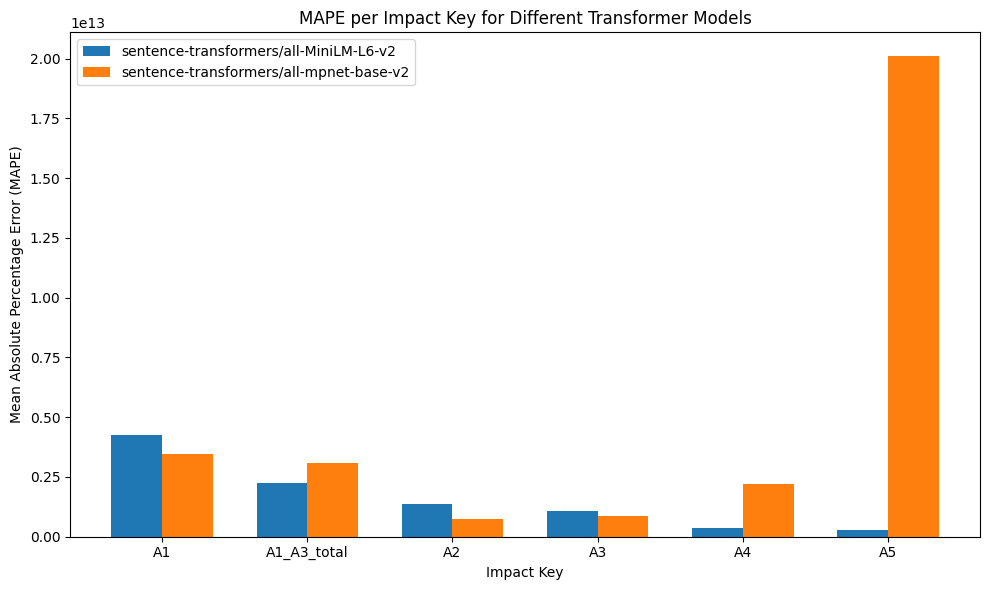

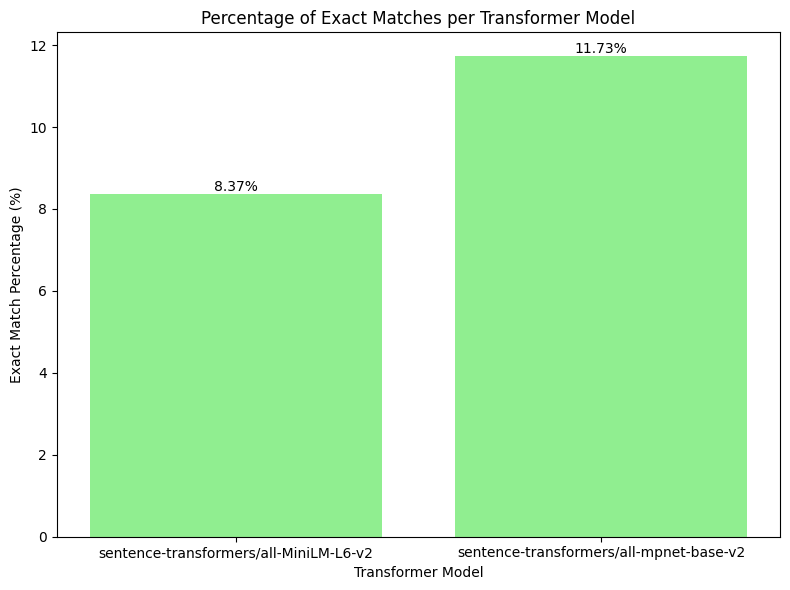

In [12]:
# ---------------------------
# Main benchmarking loop
# ---------------------------
# List of transformer model names to evaluate (adjust or add as desired)
transformer_models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
]

# Dictionaries to store evaluation results
mape_results = {}      # model_name -> mape_dict (per key)
exact_match_perc = {}  # model_name -> % of exact matches

for model_name in transformer_models:
    mape_dict, percent_exact, num_eval, _ = evaluate_transformer_detailed_mape(model_name, texts, processed_data)
    mape_results[model_name] = mape_dict
    exact_match_perc[model_name] = percent_exact

# ---------------------------
# Plotting Evaluation Graphs
# ---------------------------
# 1. Grouped Bar Plot Comparing MAPE for Each Impact Key across Transformer Models
common_keys = sorted(list(next(iter(mape_results.values())).keys()))

x = np.arange(len(common_keys))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))
for idx, model_name in enumerate(transformer_models):
    mape_vals = [mape_results[model_name].get(key, 0) for key in common_keys]
    plt.bar(x + idx*width, mape_vals, width, label=model_name)

plt.xlabel("Impact Key")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.title("MAPE per Impact Key for Different Transformer Models")
plt.xticks(x + width / 2, common_keys)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Bar Plot for Percentage of Exact Matches per Transformer Model
plt.figure(figsize=(8, 6))
models = list(exact_match_perc.keys())
exact_perc_values = [exact_match_perc[m] for m in models]
bars = plt.bar(models, exact_perc_values, color='lightgreen')
plt.xlabel("Transformer Model")
plt.ylabel("Exact Match Percentage (%)")
plt.title("Percentage of Exact Matches per Transformer Model")
for bar, perc in zip(bars, exact_perc_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{perc:.2f}%', ha='center', va='bottom')
plt.tight_layout()
plt.show()
